In [361]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import quantity_support
from astropy import constants as const
import math
from scipy import stats as sp
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
# read in the data

df = pd.read_csv('vbandgalacticmag.txt', delim_whitespace=True)

print(df)

     longitude  latitude  Avtot   N3   N4   N5   N6   N7   N8   N9  ...   N11  \
0        180.0     -90.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  14.0   
1          0.0     -80.0    0.0  0.0  0.0  0.0  0.0  0.0  3.0  3.0  ...  11.0   
2          5.0     -80.0    0.0  0.0  0.0  0.0  0.0  0.0  2.0  3.0  ...  10.0   
3         10.0     -80.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0  3.0  ...  14.0   
4         15.0     -80.0    0.0  0.0  0.0  0.0  0.0  0.0  2.0  3.0  ...  13.0   
..         ...       ...    ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
854      340.0      80.0    0.0  0.0  0.0  0.0  0.0  0.0  2.0  3.0  ...  10.0   
855      345.0      80.0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  2.0  ...  10.0   
856      350.0      80.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0  2.0  ...   6.0   
857      355.0      80.0    0.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  ...   8.0   
858      180.0      90.0    0.0  0.0  0.0  1.0  1.0  0.0  0.0  3.0  ...  11.0   

      N12   N13   N14    N1

In [28]:
# define sigma function

def sigma_v(theta, V_magnitudes):
    sigma_0, alpha_1, alpha_2, V_b, s = theta
    value = sigma_0 * (1/(10**(-s*alpha_1*(V_magnitudes-V_b)) + 10**(-s*alpha_2*(V_magnitudes-V_b)))) ** (1/s)
    return value

In [ ]:
# linear regression on the left side and then when the errors start taking off, then V_b would be at the break

In [196]:
# define x

magnitudes = np.linspace(3, 20, 18)
x = magnitudes

longitude = []
latitude = []
sigma_0 = []
sigma_0_errors = []
alpha_1 = []
alpha_1_errors = []
alpha_2 = []
alpha_2_errors = []
V_b = []
V_b_errors = []
s = []
s_errors = []

mcmc_results = []

# iterate through every row of dataframe

for index, row in df.iterrows():
    print(row[0], 'longitude')
    print(row[1], 'latitude')
        
    y = row[3:]
    yerr = np.sqrt(y)
        
        
    # run model
        
    ndim = len(theta_true)
    pos = theta_true + 1e-6 * np.random.randn(36, ndim)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr_data))
    
    sampler.run_mcmc(pos, 50000, progress=True);
    
    tau = sampler.get_autocorr_time()
    print(tau)
        
    # save walker, corner plots
        
    fig_walker, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ['sigma_0', 'alpha_1', 'alpha_2', 'V_b', 's']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
            
        axes[-1].set_xlabel("step number");
        
    fig_walker.savefig('walker and corner plots/walker plot at ' + str(row[0]) + ', ' + str(row[1]) + '.png')
        
    flat_samples = sampler.get_chain(discard=10000, thin=15, flat=True)
    fig_corner = corner.corner(flat_samples, labels=labels, truths=theta_true);
        
    fig_corner.savefig('walker and corner plots/corner plot at ' + str(row[0]) + ', ' + str(row[1]) + '.png')
        
    # save model plot
        
    for i in range(ndim):
        mcmc_i = np.percentile(flat_samples[:, i], [16, 50, 84])
        mcmc_results.append(mcmc_i)
            
    bestfit_param = (mcmc_results[0][1], mcmc_results[1][1], mcmc_results[2][1], mcmc_results[3][1], mcmc_results[4][1])
    lower_param = (mcmc_results[0][0], mcmc_results[1][0], mcmc_results[2][0], mcmc_results[3][0], mcmc_results[4][0])
    upper_param = (mcmc_results[0][2], mcmc_results[1][2], mcmc_results[2][2], mcmc_results[3][2], mcmc_results[4][2])
        
    upper_model = sigma_v(upper_param, magnitudes)
    lower_model = sigma_v(lower_param, magnitudes)
        
    fig_model, ax = plt.subplots(figsize=(14,10))
    ax.scatter(magnitudes, galactic_center_y, label = 'data', color = 'black')
    ax.plot(magnitudes, sigma_v(bestfit_param, magnitudes), color = 'black', label = 'best fit model')
    ax.errorbar(magnitudes, galactic_center_y, yerr=yerr_data, color='black', fmt='o')
    ax.fill_between(magnitudes, upper_model, lower_model, alpha=0.2, color = 'red')
    plt.title('Best-fit model at ' + str(row[0]) + ', ' + str(row[1]), fontsize = 16)
    plt.yticks(fontsize=13)
    plt.xticks(magnitudes, fontsize=13)
    plt.yscale('log')
    plt.legend()
        
    fig_model.savefig('magnitude model plots/model plot at ' + str(row[0]) + ', ' + str(row[1]) + '.png')
        
        

    # save best-fit parameters to lists
        
    longitude.append(row[0])
    latitude.append(row[1])
    sigma_0.append(mcmc_results[0][0])
    sigma_0_errors.append((mcmc_results[0][0], mcmc_results[0][2]))
    alpha_1.append(mcmc_results[1][1])
    alpha_1_errors.append((mcmc_results[1][0], mcmc_results[1][2]))
    alpha_2.append(mcmc_results[2][1])
    alpha_2_errors.append((mcmc_results[2][0], mcmc_results[2][2]))
    V_b.append(mcmc_results[3][1])
    V_b_errors.append((mcmc_results[3][0], mcmc_results[3][2]))
    s.append(mcmc_results[4][1])
    s_errors.append((mcmc_results[4][0], mcmc_results[4][2]))
        
        
    mcmc_results.clear()
        
        
        
        

/Users/sharongary/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 6/50000 [00:00<14:31, 57.33it/s]

180.0 longitude
-90.0 latitude


100%|██████████| 50000/50000 [09:04<00:00, 91.85it/s] 


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1000;
tau: [5015.61713296 2554.96311849 3601.66738252 4278.36864353 3961.14801409]

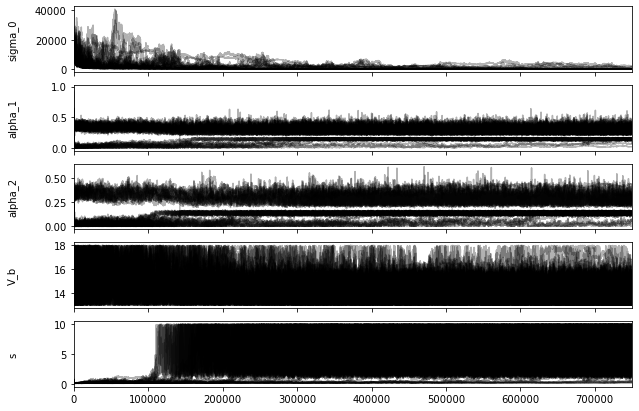

In [194]:
fig_walker, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['sigma_0', 'alpha_1', 'alpha_2', 'V_b', 's']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [ ]:
# create new dataframe

columns = ['longitude', 'latitude', 'sigma_0', 'sigma_0 errors', 'alpha_1', 'alpha_1 errors', 'alpha_2', 'alpha_2 errors', 'V_b', 'V_b errors', 's', 's errors']





     longitude  latitude  Avtot   N3   N4   N5   N6   N7   N8    N9  ...  \
430      180.0       0.0    0.0  0.0  0.0  0.0  0.0  2.0  2.0  13.0  ...   

       N11    N12    N13     N14     N15     N16     N17     N18      N19  \
430  101.0  246.0  541.0  1223.0  2170.0  4081.0  6498.0  9652.0  12556.0   

         N20  
430  15080.0  

[1 rows x 21 columns]
N3         0.0
N4         0.0
N5         0.0
N6         0.0
N7         2.0
N8         2.0
N9        13.0
N10       38.0
N11      101.0
N12      246.0
N13      541.0
N14     1223.0
N15     2170.0
N16     4081.0
N17     6498.0
N18     9652.0
N19    12556.0
N20    15080.0
Name: 430, dtype: float64


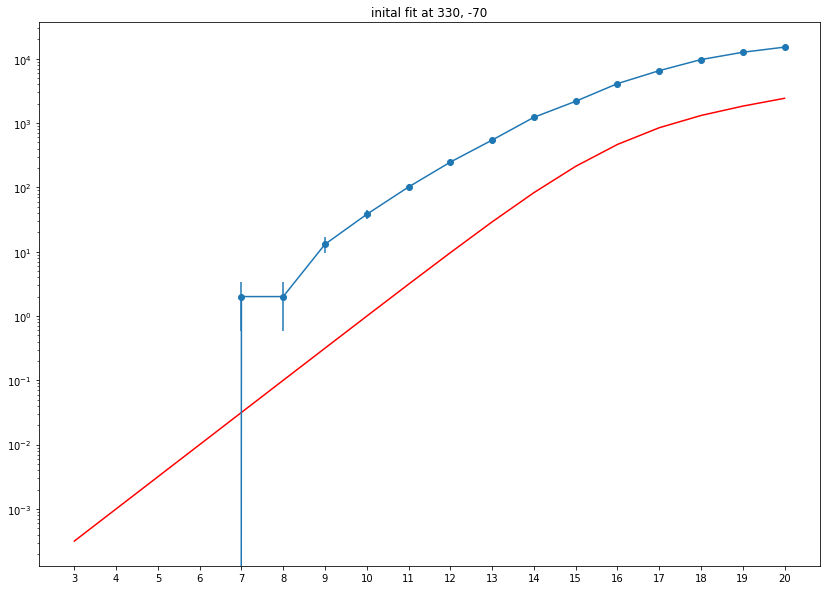

In [366]:
selected_row = df.loc[(df['longitude'] == 180) & (-1 < df['latitude']) & (df['latitude'] < 1) ]

print(selected_row)

selected_row_y = selected_row.iloc[0,3:]

print(selected_row_y)

magnitudes = np.linspace(3, 20, 18)

yerr_data = np.sqrt(selected_row_y)
param = (1000, 0.5, 0.1, 16, 0.9)
fig_initial = plt.subplots(figsize=(14,10))
plt.scatter(magnitudes, selected_row_y)
plt.plot(magnitudes, sigma_v(param, magnitudes), 'red')
plt.errorbar(magnitudes, selected_row_y, yerr=yerr_data)
plt.xticks(magnitudes)
plt.title('inital fit at 330, -70')
plt.yscale('log')
# plt.ylim(1, 10e5)
plt.show()

# at 240 -8: (13000, 0.5, 0.1, 16, 0.9) (good initial fit)

In [367]:
sigma_0, alpha_1, alpha_2, V_b, s = param

theta_true = sigma_0, alpha_1, alpha_2, V_b, s

def log_likelihood(theta, x, y, yerr):
    sigma_0, alpha_1, alpha_2, V_b, s = theta
    model = sigma_v(theta, x)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [368]:
def log_prior(theta):
    sigma_0, alpha_1, alpha_2, V_b, s = theta
    if 0.0 < sigma_0 <= 1e5 and 0.0 < alpha_1 < 1.0 and 0.0 < alpha_2 < 1.0 and 10 <= V_b <= 18.0 and 0.0 < s < 10:
        return 0.0
    return -np.inf



In [369]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [370]:
import emcee

ndim = len(theta_true)
pos = theta_true + 1e-6 * np.random.randn(36, ndim)
nwalkers, ndim = pos.shape

x = magnitudes
y = selected_row_y

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr_data)
)
sampler.run_mcmc(pos, 30000, progress=True);

/Users/sharongary/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 30000/30000 [06:47<00:00, 73.63it/s]


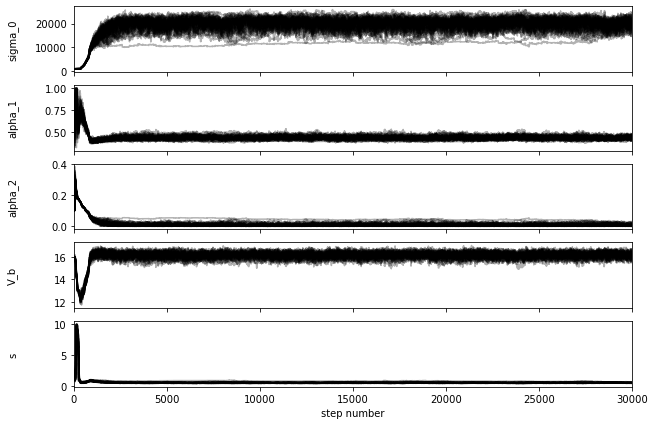

In [371]:
fig_walker, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['sigma_0', 'alpha_1', 'alpha_2', 'V_b', 's']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

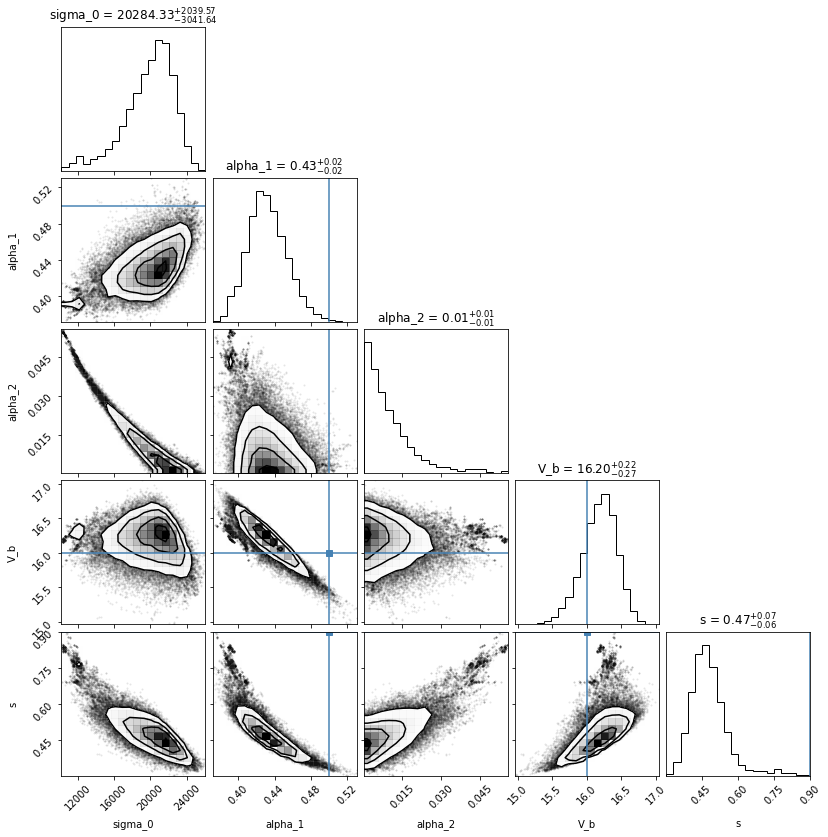

In [372]:
flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)

import corner

fig_corner = corner.corner(
    flat_samples, labels=labels, truths=theta_true, show_titles = True);

In [373]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [374]:
mcmc = []
for i in range(ndim):
    mcmc_i = np.percentile(flat_samples[:, i], [16, 50, 84])
    mcmc.append(mcmc_i)
mcmc = np.array(mcmc)

bestfit_param = (mcmc[0][1], mcmc[1][1], mcmc[2][1], mcmc[3][1], mcmc[4][1])

4.784215745844378


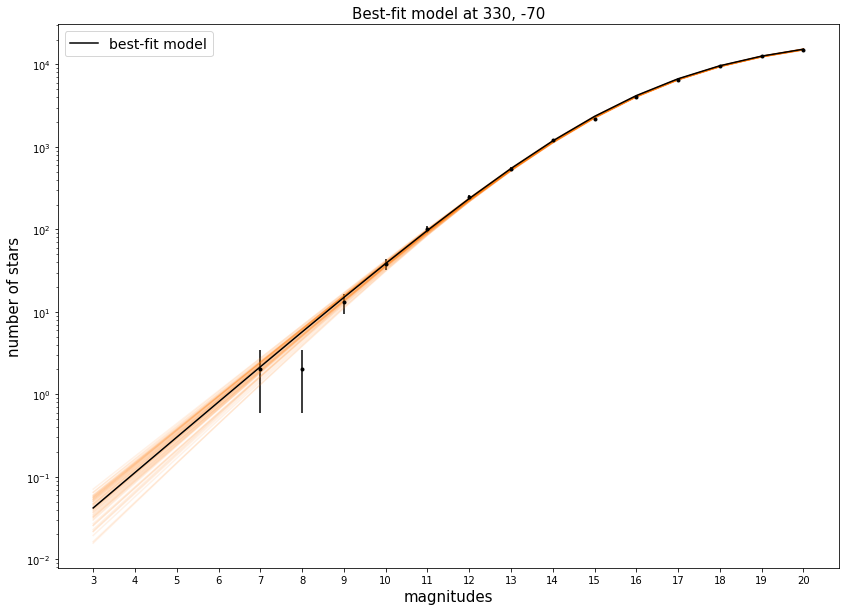

In [376]:
inds = np.random.randint(low = 25000, high = 30000, size=50)
# print(inds)
fig_model, ax = plt.subplots(figsize=(14,10))
for ind in inds:
    sample = flat_samples[ind]
    model_trial = sigma_v(sample, x)
    plt.plot(x, model_trial, "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr_data, fmt=".k", capsize=0)
plt.plot(x, sigma_v(bestfit_param, x), "k", label="best-fit model")
plt.legend(fontsize=14)
plt.xticks(magnitudes)
# plt.ylim(1e-2, 1e3)
plt.title('Best-fit model at 330, -70', fontsize = 15)
plt.yscale('log')
plt.xlabel("magnitudes", fontsize = 15)
plt.ylabel("number of stars", fontsize = 15);

chi_squared = (y - sigma_v(bestfit_param, x))**2 / (sigma_v(bestfit_param, x))

print(sum(chi_squared) / 7)

In [333]:
selected_df

,longitude,latitude,Avtot,N3,N4,N5,N6,N7,N8,N9,...,N11,N12,N13,N14,N15,N16,N17,N18,N19,N20
0,180.0,-90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,14.0,24.0,30.0,51.0,97.0,146.0,149.0,254.0,308.0,484.0
10,120.0,-80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,7.0,28.0,31.0,71.0,91.0,113.0,192.0,214.0,322.0,439.0
20,345.0,-80.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,17.0,23.0,40.0,76.0,100.0,151.0,225.0,281.0,385.0,502.0
30,70.0,-70.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,...,10.0,18.0,45.0,67.0,102.0,141.0,208.0,269.0,390.0,555.0
40,330.0,-70.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,15.0,24.0,38.0,87.0,120.0,170.0,266.0,324.0,462.0,624.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,340.0,60.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,...,13.0,26.0,44.0,102.0,141.0,200.0,298.0,445.0,611.0,830.0
820,50.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,10.0,24.0,39.0,66.0,110.0,152.0,217.0,296.0,391.0,545.0
830,310.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,8.0,25.0,47.0,69.0,111.0,147.0,233.0,300.0,422.0,541.0
840,20.0,80.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,...,8.0,18.0,48.0,65.0,92.0,143.0,198.0,273.0,342.0,500.0


  0%|          | 7/30000 [00:00<08:07, 61.58it/s]

180.0 longitude
-90.0 latitude
N3       0.0
N4       0.0
N5       0.0
N6       0.0
N7       0.0
N8       0.0
N9       2.0
N10      3.0
N11     14.0
N12     24.0
N13     30.0
N14     51.0
N15     97.0
N16    146.0
N17    149.0
N18    254.0
N19    308.0
N20    484.0
Name: 0, dtype: float64


100%|██████████| 30000/30000 [05:27<00:00, 91.69it/s] 


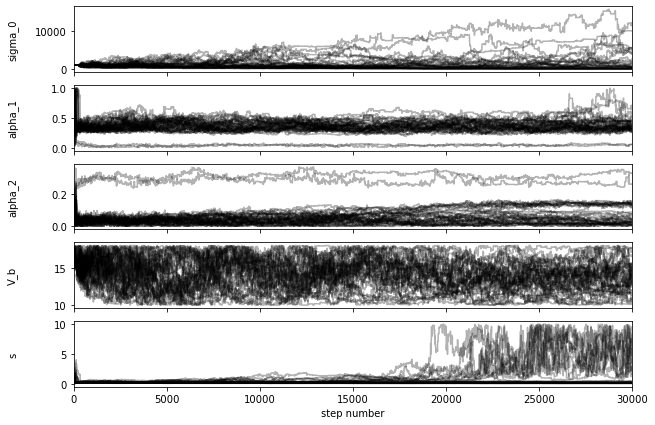

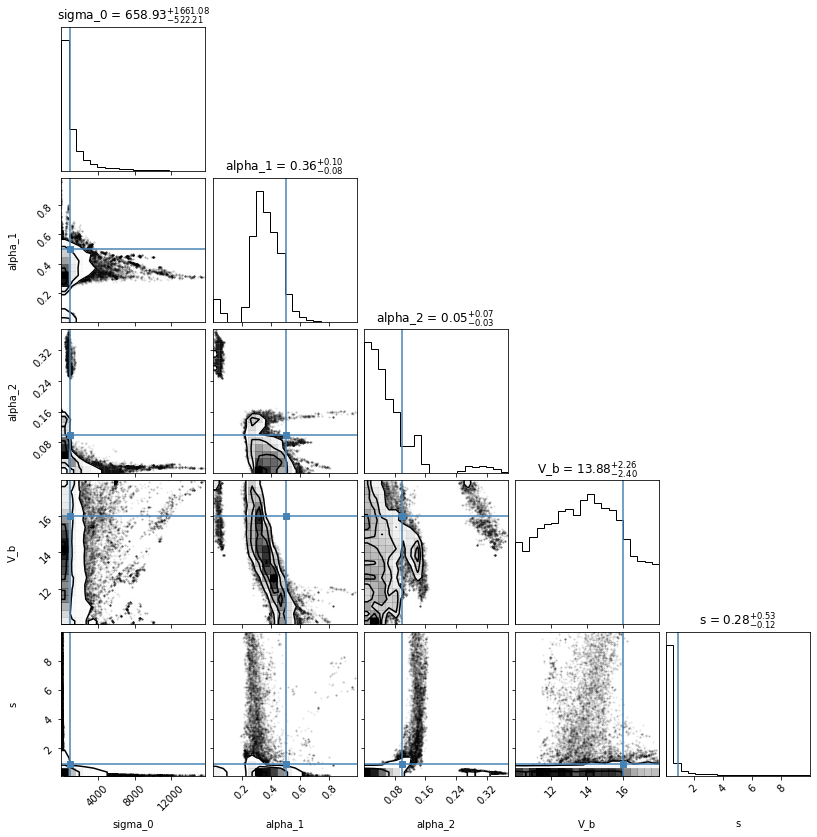

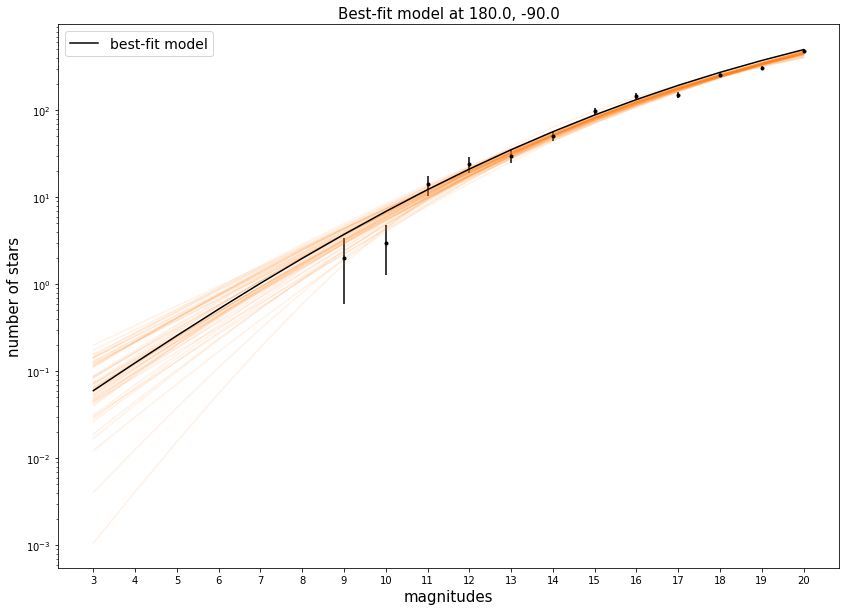

/Users/sharongary/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 7/30000 [00:00<08:07, 61.56it/s]

120.0 longitude
-80.0 latitude
N3       0.0
N4       0.0
N5       0.0
N6       0.0
N7       0.0
N8       0.0
N9       2.0
N10      6.0
N11      7.0
N12     28.0
N13     31.0
N14     71.0
N15     91.0
N16    113.0
N17    192.0
N18    214.0
N19    322.0
N20    439.0
Name: 10, dtype: float64


100%|██████████| 30000/30000 [05:39<00:00, 88.26it/s] 


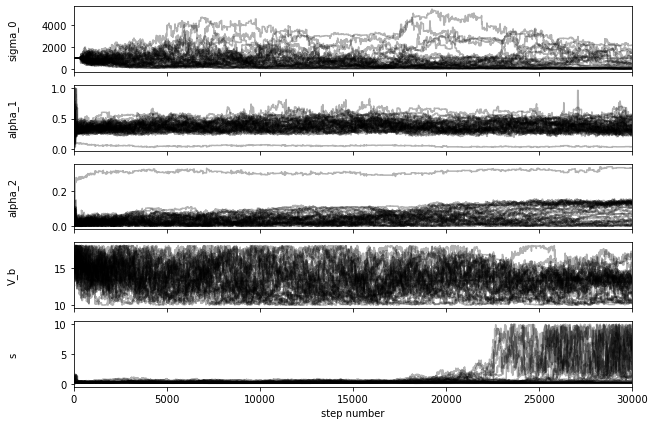

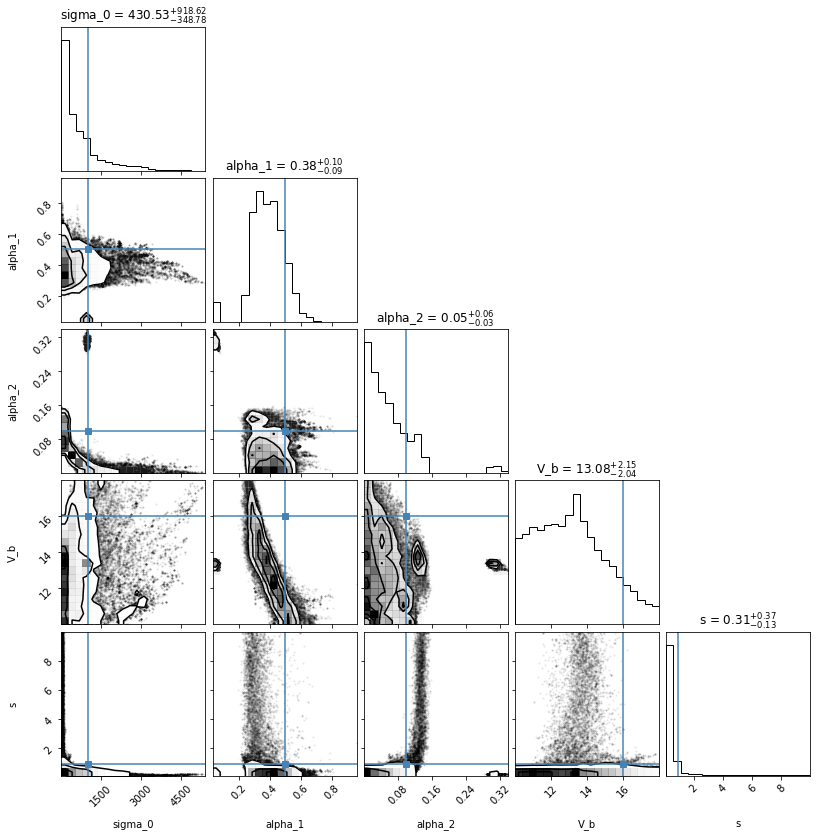

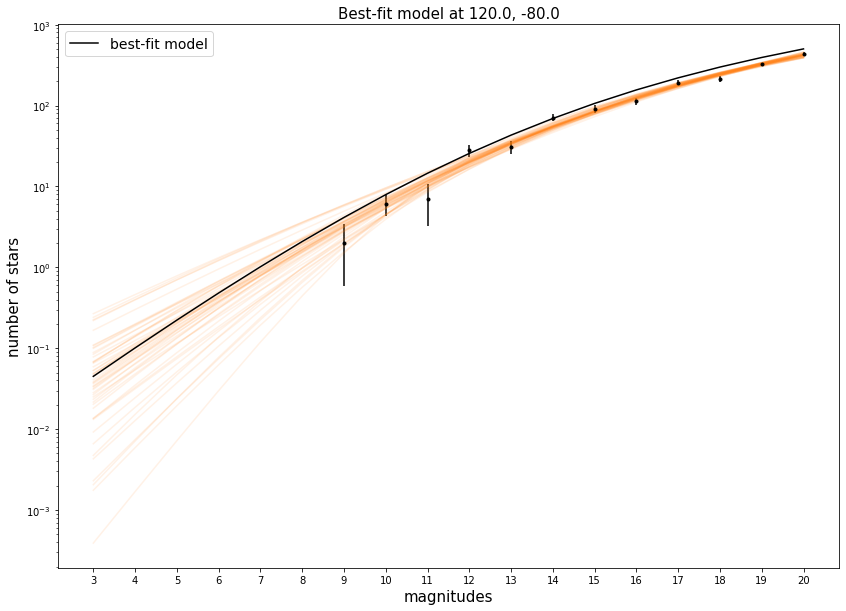

/Users/sharongary/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 7/30000 [00:00<08:04, 61.94it/s]

345.0 longitude
-80.0 latitude
N3       0.0
N4       0.0
N5       0.0
N6       0.0
N7       0.0
N8       1.0
N9       0.0
N10      3.0
N11     17.0
N12     23.0
N13     40.0
N14     76.0
N15    100.0
N16    151.0
N17    225.0
N18    281.0
N19    385.0
N20    502.0
Name: 20, dtype: float64


100%|██████████| 30000/30000 [06:04<00:00, 82.30it/s]


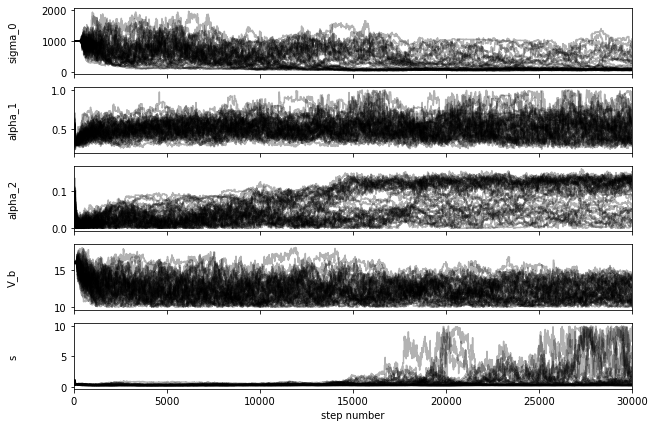

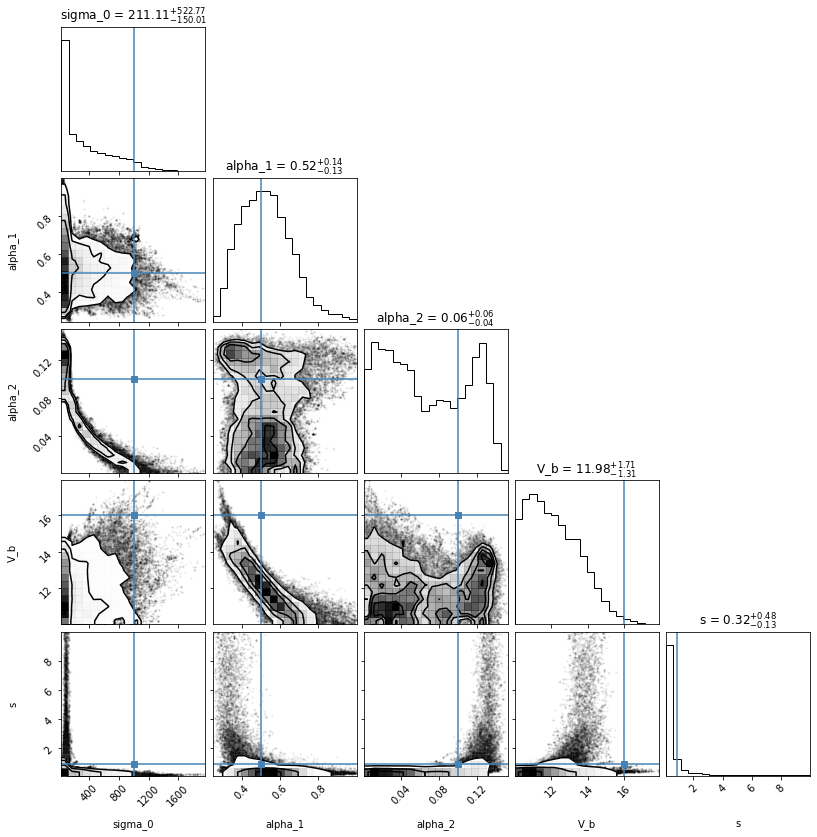

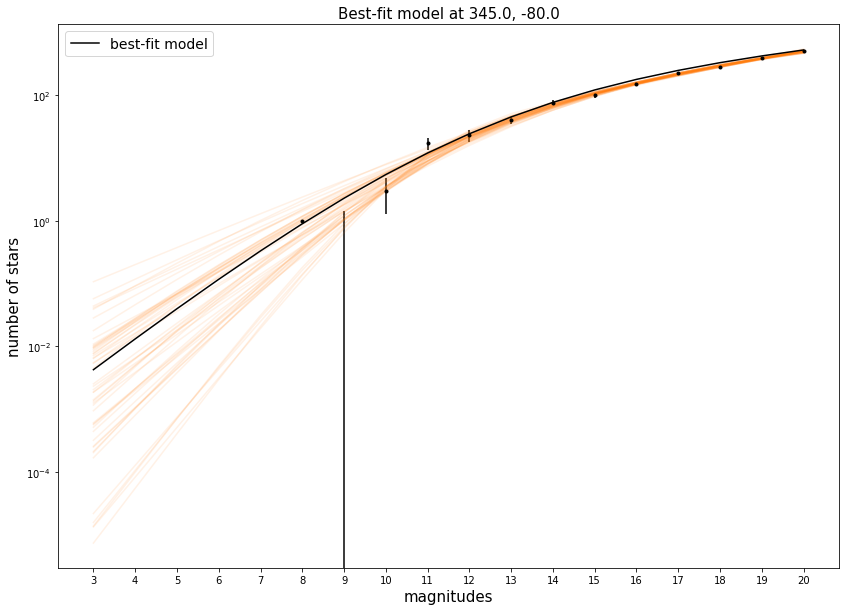

/Users/sharongary/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 7/30000 [00:00<08:07, 61.48it/s]

70.0 longitude
-70.0 latitude
N3       0.0
N4       1.0
N5       0.0
N6       0.0
N7       2.0
N8       2.0
N9       0.0
N10      5.0
N11     10.0
N12     18.0
N13     45.0
N14     67.0
N15    102.0
N16    141.0
N17    208.0
N18    269.0
N19    390.0
N20    555.0
Name: 30, dtype: float64


 37%|███▋      | 10963/30000 [02:14<03:50, 82.65it/s]Traceback (most recent call last):
  File "/Users/sharongary/opt/anaconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-315-726be20abc9c>", line 5, in log_probability
    return lp + log_likelihood(theta, x, y, yerr)
  File "<ipython-input-313-02ba9e412e80>", line 9, in log_likelihood
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
  File "<__array_function__ internals>", line 5, in sum
  File "/Users/sharongary/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 2247, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/Users/sharongary/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 85, in _wrapreduction
    return reduction(axis=axis, out=out, **passkwargs)
  File "/Users/sharongary/opt/anaconda3/lib/python3.8/site-packages

emcee: Exception while calling your likelihood function:
  params: [4.30645536e+02 4.55150023e-01 4.79253248e-02 1.14528968e+01
 1.98047389e-01]
  args: (array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20.]), N3       0.0
N4       1.0
N5       0.0
N6       0.0
N7       2.0
N8       2.0
N9       0.0
N10      5.0
N11     10.0
N12     18.0
N13     45.0
N14     67.0
N15    102.0
N16    141.0
N17    208.0
N18    269.0
N19    390.0
N20    555.0
Name: 30, dtype: float64, N3      0.000000
N4      0.000000
N5      0.000000
N6      0.000000
N7      0.000000
N8      0.000000
N9      1.414214
N10     1.732051
N11     3.741657
N12     4.898979
N13     5.477226
N14     7.141428
N15     9.848858
N16    12.083046
N17    12.206556
N18    15.937377
N19    17.549929
N20    22.000000
Name: 0, dtype: float64)
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [340]:
# define x

magnitudes = np.linspace(3, 20, 18)
x = magnitudes

# iterate through every row of dataframe

selected_df = df.iloc[0::10, :]

for index, row in selected_df.iterrows():
    
    print(row[0], 'longitude')
    print(row[1], 'latitude')
      
    y = row[3:]
    yerr = np.sqrt(y)
    
    print(y)

        
    # run model
        
    ndim = len(theta_true)
    pos = theta_true + 1e-6 * np.random.randn(36, ndim)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr_data))
    
    sampler.run_mcmc(pos, 30000, progress=True);
    
        
    # save walker, corner plots
        
    fig_walker, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ['sigma_0', 'alpha_1', 'alpha_2', 'V_b', 's']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
            
        
#     fig_walker.savefig('walker and corner plots/walker plot at ' + str(row[0]) + ', ' + str(row[1]) + '.png')
        
    flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)
    fig_corner = corner.corner(flat_samples, labels=labels, truths=theta_true, show_titles = True);
        
#     fig_corner.savefig('walker and corner plots/corner plot at ' + str(row[0]) + ', ' + str(row[1]) + '.png')
        
    # save model plot
        
    mcmc = []
    for i in range(ndim):
        mcmc_i = np.percentile(flat_samples[:, i], [16, 50, 84])
        mcmc.append(mcmc_i)

    bestfit_param = (mcmc[0][1], mcmc[1][1], mcmc[2][1], mcmc[3][1], mcmc[4][1])
                    
    inds = np.random.randint(low = 20000, high = 30000, size=50)

    fig_model, ax = plt.subplots(figsize=(14,10))
    for ind in inds:
        sample = flat_samples[ind]
        model_trial = sigma_v(sample, x)
        plt.plot(x, model_trial, "C1", alpha=0.1)
    plt.errorbar(x, y, yerr=yerr_data, fmt=".k", capsize=0)
    plt.plot(x, sigma_v(bestfit_param, x), "k", label="best-fit model")
    plt.legend(fontsize=14)
    plt.xticks(magnitudes)
    plt.title('Best-fit model at ' + str(row[0]) + ', ' + str(row[1]), fontsize = 15)
    plt.yscale('log')
    plt.xlabel("magnitudes", fontsize = 15)
    plt.ylabel("number of stars", fontsize = 15)
    plt.show()
        
#     fig_model.savefig('magnitude model plots/model plot at ' + str(row[0]) + ', ' + str(row[1]) + '.png')
    
    figs = [fig_walker, fig_corner, fig_model] # list of figures
    with PdfPages(str(row[0]) + ', ' + str(row[1]) + ' figures.pdf') as pdf:
        for fig in figs:
            pdf.savefig(fig, bbox_inches='tight')

    mcmc.clear()
    
    

In [338]:
figs = [fig_walker, fig_corner, fig_model] # list of figures
with PdfPages('tenth row pdfs/' + str(row[0]) + ', ' + str(row[1]) + ' figures.pdf') as pdf:
    for fig in figs:
        pdf.savefig(fig, bbox_inches='tight')

        

AttributeError: 'NoneType' object has no attribute 'finalize'